In [39]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
# Set Seaborn style
sns.set(style='darkgrid', font_scale=1.2)
from sklearn.datasets import make_moons, make_blobs

## Progress bar
from tqdm.notebook import tqdm

import torch
print("Using torch", torch.__version__)
#torch.manual_seed(42) # Setting the seed
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.distributions.multivariate_normal import MultivariateNormal

from torch.utils.tensorboard import SummaryWriter
import torch.profiler

from GPUtil import showUtilization as gpu_usage

Using torch 1.13.1


In [40]:
class langevin_sampler():
    class langevin_sampler:
        """
        A class for sampling from a distribution using Langevin dynamics.

        Args:
        - p0_sigma (float): the standard deviation of the initial prior distribution
        - batch_size (int): the number of samples to generate at once
        - num_latent_samples (int): the number of latent variables to produce during a sampling loop
        - device (str): the device to use for computation (e.g. 'cpu' or 'cuda')

        Methods:
        - get_sample(initial_sample, data, model, EBMmodel=None): generates a sample using Langevin dynamics
        - sample_p0(): generates a sample from the initial prior distribution
        """
    def __init__(self, p0_sigma, batch_size, num_latent_samples, device):
        self.device = device
        self.p0_sigma = p0_sigma
        self.batch_size = batch_size
        self.num_z = num_latent_samples

    def get_sample(self, initial_sample, data, model, EBMmodel = None):
        """
        MCMC sampling using Langevin dynamics. Is used to generated samples from both the exp-tilter prior and the posterior.

        Args:
            initial_sample (tensor): The initial sample before the loop begins.
            data (tensor): The training data, which is solely used in the gradient computation for the posterior sampling procedure.
            model (class): The model used for the sampling procedure. EBM for exp-tilter prior, Generator for posterior.
            EBMmodel (class): Used solely for the posterior sampling procedure. The EBM model is also used in calculation of the posterior gradient.

        Returns:
            x_k (tensor): The final sample
        """
        x_k = initial_sample
        
        step = 0
        
        while step < model.K:
            # Compute gradient
            grad = model.grad_log_fn(x_k, data, EBMmodel)
            
            # Update sample
            x_k = x_k + (model.s * model.s * grad) + (torch.sqrt(torch.tensor(2)) * model.s * torch.randn_like(x_k, device=self.device))  

            step += 1             
        
        return x_k
    
    def sample_p0(self):
        """
        Sample form the initial prior distribution.

        Returns:
            z0: A normally distributed variable
        """
        return self.p0_sigma * torch.randn(self.batch_size, self.num_z, device=self.device, requires_grad=True)

In [41]:
class tiltedpriorEBM(nn.Module):
    def __init__(self, input_dim, output_dim, p0_sigma, langevin_steps=20, langevin_s=0.4):
        super().__init__()
        
        self.s = langevin_s # This is s in langevin sampler
        self.K = langevin_steps # Number of steps the langevin sampler takes
        self.p0_sigma = p0_sigma # Standard deviation of z0
        
        self.layers = nn.Sequential(
                    nn.Linear(input_dim, 256), 
                    nn.ReLU(),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Linear(128, output_dim),
                )
            
    def forward(self, z):
        # Returns f_a(z)
        return self.layers(z)
    
    def grad_log_fn(self, z, x, model):
        
        # Compute gradient of log p_a(x) w.r.t. z
        f_z = self.forward(z)
        grad_f_z = torch.autograd.grad(f_z.sum(), z, create_graph=True)[0] # Gradient of f_a(z)
        
        return grad_f_z - (z / (self.p0_sigma * self.p0_sigma)) # This is GRAD log[p_a(x)]

In [42]:
class temperedGenerator(nn.Module):
    def __init__(self, input_dim, output_dim, lkhood_sigma, langevin_steps=20, langevin_s=0.1, temp_schedule='uniform', num_temps=10):
        super().__init__()
        
        self.s = langevin_s # This is s in langevin sampler
        self.K = langevin_steps # Number of steps the langevin sampler takes
        self.lkhood_sigma = lkhood_sigma
        self.grad_log_prior = 0
        self.temperature_schedule(temp_schedule, num_temps)
        self.t_index=0
        
        self.layers = nn.Sequential(
                    nn.Linear(input_dim, 256), 
                    nn.ReLU(),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Linear(128, output_dim),
                )
    
    def forward(self, z):
        g_z = self.layers(z)
        return g_z
    
    def grad_log_fn(self, z, x, EBM_model):
        
        # Compute gradient of t * log[p(x | z)] w.r.t z
        g_z = self.forward(z)
        log_llood = - self.schedule[self.t_index] * (torch.norm(x-g_z, dim=-1)**2) / (2.0 * self.lkhood_sigma * self.lkhood_sigma)
        grad_log_llhood = torch.autograd.grad(log_llood.sum(), z, create_graph=True)[0]
        
        # Compute gradient of log[p(z)] w.r.t z
        f_z = EBM_model.forward(z)
        grad_f_z = torch.autograd.grad(f_z.sum(), z, create_graph=True)[0] # Gradient of f_a(z)
        grad_log_prior = grad_f_z - (z / (EBM_model.p0_sigma * EBM_model.p0_sigma))
        
        return grad_log_llhood + grad_log_prior # This is GRAD log[ p(x | z)^t * p(z) ]

    def temperature_schedule(self, schedule_name, num_temps):

        if schedule_name == 'uniform':
            self.schedule = torch.tensor([i / num_temps for i in range(num_temps)])
            self.delta_t = torch.ones_like(self.schedule) * (1.0 / num_temps)
        else:
            raise ValueError('Unknown schedule name: {}'.format(schedule_name))

In [43]:
def EBM_loss(z_prior, z_posterior, EBMmodel):
    en_pos = EBMmodel(z_posterior.detach())
    en_neg = EBMmodel(z_prior.detach())
            
    return (en_pos - en_neg).mean()
        
def generator_loss(x, g_z, lkhood_sigma):
    
    log_lkhood = (torch.norm(x-g_z, dim=-1)**2) / (2.0 * lkhood_sigma * lkhood_sigma)
    
    return log_lkhood.mean()

lossE = EBM_loss
#lossG = nn.MSELoss(reduction='mean')
lossG = generator_loss

Using cpu device


  0%|          | 0/100 [00:00<?, ?it/s]

STAGE:2023-12-04 13:52:47 212975:212975 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-12-04 13:52:51 212975:212975 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-12-04 13:54:12 212975:212975 output_json.cpp:417] Completed Stage: Post Processing


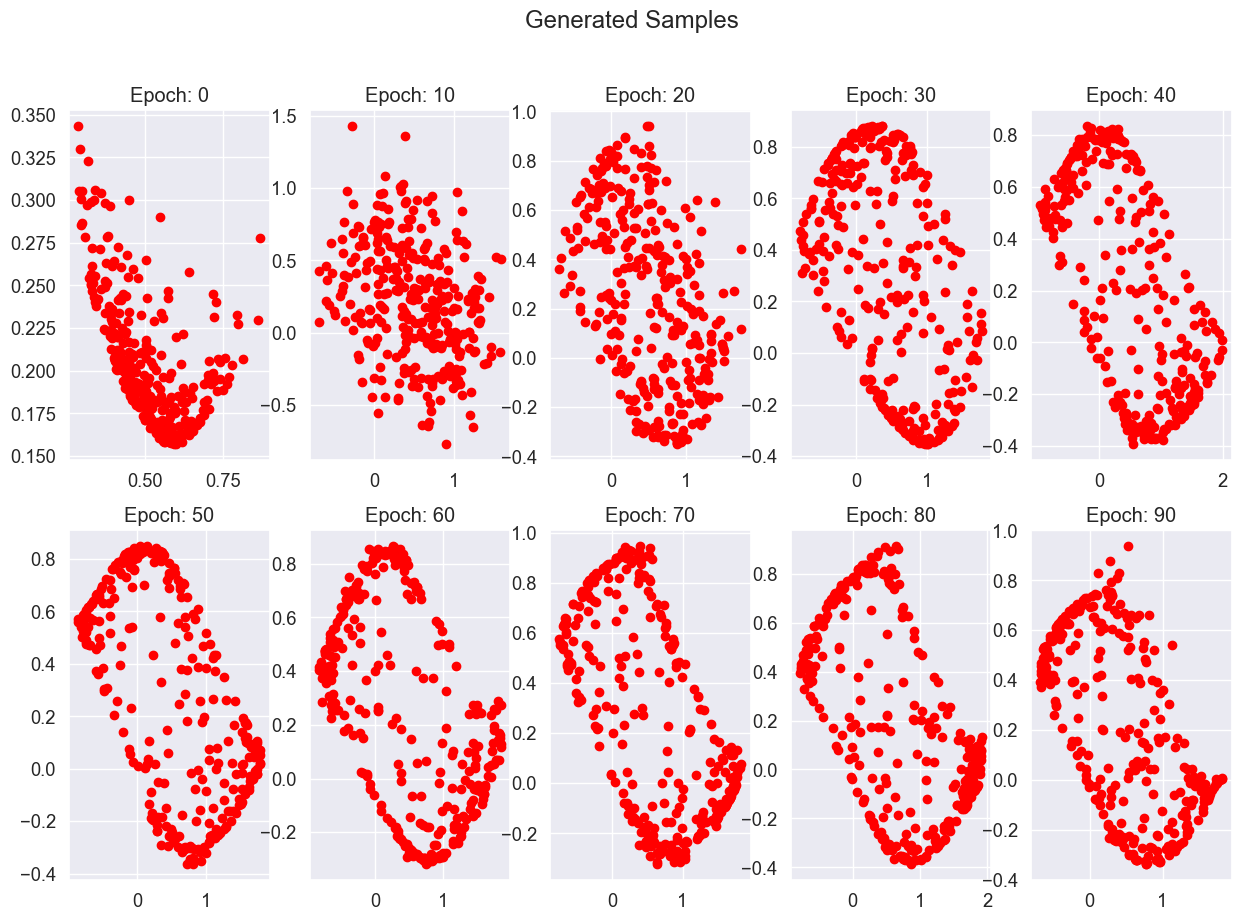

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Hyperparameters
NUM_EPOCHS = 100
BATCH_SIZE = 32
DATA_SAMPLES = 2000

Z_SAMPLES = 2

E_LR = 0.0002
G_LR = 0.001

E_STEP = 0.2
G_STEP = 0.1

E_SAMPLE_STEPS = 80
G_SAMPLE_STEPS = 80

p0_SIGMA = 0.2
GENERATOR_SIGMA = 0.1

NUM_TEMPS = 10

# Load the moons dataset
X, _ = make_moons(n_samples=DATA_SAMPLES, noise=0.1)
#X, _ = make_blobs(n_samples=DATA_SAMPLES, centers=2, n_features=2, cluster_std=0.5, random_state=0)
X = torch.tensor(X).float().to(device)
loader = DataLoader(X, batch_size=BATCH_SIZE, shuffle=True)

Sampler = langevin_sampler(
    p0_sigma=p0_SIGMA, 
    batch_size=BATCH_SIZE, 
    num_latent_samples=Z_SAMPLES, 
    device=device
)

EBMnet = tiltedpriorEBM(
    input_dim=Z_SAMPLES, 
    output_dim=Z_SAMPLES, 
    p0_sigma=p0_SIGMA, 
    langevin_steps=E_SAMPLE_STEPS, 
    langevin_s=E_STEP
).to(device)

GENnet = temperedGenerator(
    input_dim=Z_SAMPLES, 
    output_dim=X.shape[1], 
    lkhood_sigma=GENERATOR_SIGMA, 
    langevin_steps=G_SAMPLE_STEPS, 
    langevin_s=G_STEP,
    temp_schedule='uniform',
    num_temps=NUM_TEMPS
).to(device)

EBMoptimiser = torch.optim.Adam(EBMnet.parameters(), lr=E_LR)
GENoptimiser = torch.optim.Adam(GENnet.parameters(), lr=G_LR)

# Write to tensorboard 10 times
sample_every = NUM_EPOCHS//10
writer = SummaryWriter(f"runs/TemperedEBM")
num_plots = (NUM_EPOCHS // sample_every)-1
num_cols = min(5, num_plots)  # Maximum of 2 columns
num_rows = (num_plots - 1) // num_cols + 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle("Generated Samples")

tqdm_bar = tqdm(range(NUM_EPOCHS))

with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./runs/TemperedEBM/profilerlogs'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
) as prof:
    for epoch in tqdm_bar:
        EBMtotal_loss = 0
        GENtotal_loss = 0
        for batch_idx, x in enumerate(loader): 

            batch_size = x.shape[0]
            loss_gen = 0
            loss_ebm = 0
            
            lossG_prev = 0
            lossE_prev = 0
            
            for i in range(1, len(GENnet.schedule)):
                GENnet.t_index = i
                
                # 1a. Sample from latent prior p0(z)
                z0 = Sampler.sample_p0()
                
                # 1b. Sample from posterior p_theta(z | x) and prior p_a(z)
                zK_EBM = Sampler.get_sample(z0, None, EBMnet, None).detach()
                zK_GEN = Sampler.get_sample(z0, x, GENnet, EBMnet).detach()
                
                # 2. Get loss at temperature t
                x_pred = GENnet(zK_GEN) + (GENnet.lkhood_sigma * torch.randn_like(x))
                lossG_current = lossG(x, x_pred, GENnet.lkhood_sigma)
                lossE_current = lossE(zK_EBM, zK_GEN, EBMnet)
                
                # See "discretised thermodynamic integration" using trapezoid rule
                loss_gen += 0.5 * (lossG_current + lossG_prev) * GENnet.delta_t[i]
                loss_ebm += 0.5 * (lossE_current + lossE_prev) * GENnet.delta_t[i]
                
                lossG_prev = lossG_current
                lossE_prev = lossE_current
            
            # 3. Update parameters 
            GENoptimiser.zero_grad()   
            loss_gen.backward()
            GENoptimiser.step()
            EBMoptimiser.zero_grad()
            loss_ebm.backward()
            EBMoptimiser.step()
            
            EBMtotal_loss += loss_ebm.item()  
            GENtotal_loss += loss_gen.item()
            
            prof.step()
            if batch_idx >= 5:
                break

        tqdm_bar.set_description(f"Epoch {epoch}: EBM-Loss: {EBMtotal_loss / (BATCH_SIZE):.4f} GEN-Loss: {GENtotal_loss / (BATCH_SIZE):.4f}")

        if (epoch % sample_every == 0 or epoch == NUM_EPOCHS):
            
            # # Plot a batch of generated samples
            # 

            plot_num = (epoch // sample_every) 
            row = plot_num // num_cols
            col = (plot_num % num_cols)
            #axs[row, col].clear()
            axs[row, col].set_title(f'Epoch: {epoch}')

            # For loop to generate 10x as many samples as there are in the batch. (10 * BATCH_SIZE datapoints will be plotted)
            for _ in range(10):
                # Assuming the prior has matched the posterior in training, we can sample from the prior
                z = Sampler.sample_p0()
                z_prior = Sampler.get_sample(z, None, EBMnet, None)
                with torch.no_grad():
                    x_pred = GENnet(z_prior) 
                    samples = x_pred.cpu().detach()
                    axs[row, col].scatter(x=samples[:, 0].numpy(), y=samples[:, 1].numpy(), color='red', marker='o')
                

            # Convert the Matplotlib figure to a NumPy array
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            # Write the image to TensorBoard
            writer.add_image("TemperedEBM -- Make Moons", image, global_step=epoch, dataformats='HWC')
            Sampler.batch_size = BATCH_SIZE

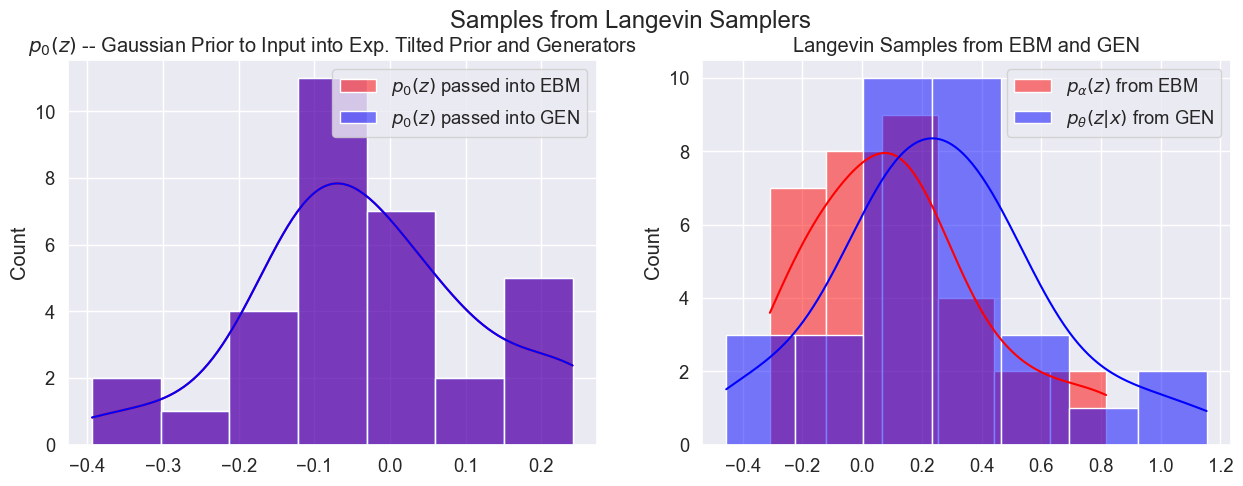

In [45]:
# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Samples from Langevin Samplers")

# Sample from the prior distribution
z0_EBM = Sampler.sample_p0() 
z0_GEN = z0_EBM.clone()

# Mean along the final dimension
z0_EBM_mean = torch.mean(z0_EBM, dim=-1)
z0_GEN_mean = torch.mean(z0_GEN, dim=-1)

# Plot the histograms
sns.histplot(z0_EBM_mean.detach().cpu().numpy(), ax=axs[0], color='red', kde=True, label='$p_0(z)$ passed into EBM')
sns.histplot(z0_GEN_mean.detach().cpu().numpy(), ax=axs[0], color='blue', kde=True, label='$p_0(z)$ passed into GEN')
axs[0].set_title(r'$p_0(z)$ -- Gaussian Prior to Input into Exp. Tilted Prior and Generators')
axs[0].legend()

# Sample from the posterior distribution and plot the results
zK_EBM = Sampler.get_sample(z0_EBM, None, EBMnet, None)
zK_GEN = Sampler.get_sample(zK_EBM, x, GENnet, EBMnet)

# Mean along the final dimension
zK_EBM_mean = torch.mean(zK_EBM, dim=-1)
zK_GEN_mean = torch.mean(zK_GEN, dim=-1)

# Plot the histograms
sns.histplot(zK_EBM_mean.detach().cpu().numpy(), ax=axs[1], color='red', kde=True, label=r'$p_\alpha(z)$ from EBM')
sns.histplot(zK_GEN_mean.detach().cpu().numpy(), ax=axs[1], color='blue', kde=True, label=r'$p_\theta(z|x)$ from GEN')
axs[1].set_title('Langevin Samples from EBM and GEN')
axs[1].legend()

Text(0.5, 1.0, 'Denerated Dist. -- z sampled from $p_\\theta(z|x)$')

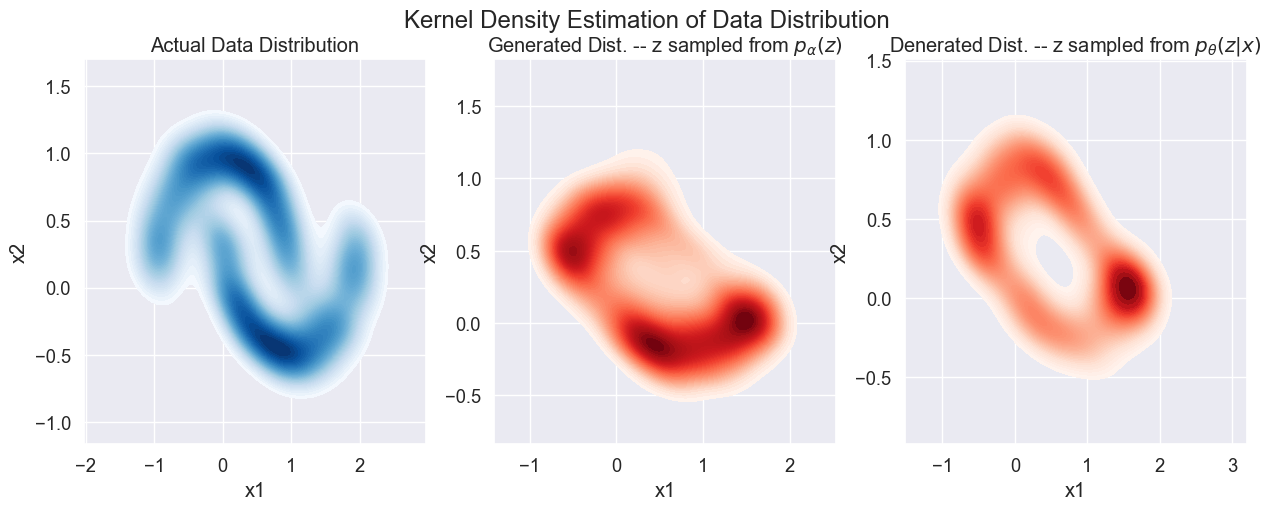

In [46]:
import pandas as pd

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Kernel Density Estimation of Data Distribution")

Sampler.batch_size = X.shape[0]

# Sample from the prior distribution and plot the results
z0_EBM = Sampler.sample_p0() 
z0_GEN = Sampler.sample_p0()

# Sample from the posterior distribution and plot the results
zK_EBM = Sampler.get_sample(z0_EBM, None, EBMnet, None)
zK_GEN = Sampler.get_sample(zK_EBM, X, GENnet, EBMnet)

X_pred1 = GENnet(zK_EBM.detach()) + (GENnet.lkhood_sigma * torch.randn_like(X))
X_pred2 = GENnet(zK_GEN.detach()) + (GENnet.lkhood_sigma * torch.randn_like(X))

# Create a dataframe with the dataset
df1 = pd.DataFrame({'x1': X[:, 0], 'x2': X[:, 1]})

# Generate the heatmap
sns.kdeplot(data=df1, x='x1', y='x2', fill=True, cmap='Blues', levels=50, ax=axs[0])
axs[0].set_title('Actual Data Distribution')

df2 = pd.DataFrame({'x1': X_pred1[:, 0].detach().cpu(), 'x2': X_pred1[:, 1].detach().cpu()})

# Generate the heatmap  
sns.kdeplot(data=df2, x='x1', y='x2', fill=True, cmap='Reds', levels=50, ax=axs[1])
axs[1].set_title(r'Generated Dist. -- z sampled from $p_\alpha(z)$')

df2 = pd.DataFrame({'x1': X_pred2[:, 0].detach().cpu(), 'x2': X_pred2[:, 1].detach().cpu()})

# Generate the heatmap  
sns.kdeplot(data=df2, x='x1', y='x2', fill=True, cmap='Reds', levels=50, ax=axs[2])
axs[2].set_title(r'Generated Dist. -- z sampled from $p_\theta(z|x)$')




